In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, KNNBasic, NMF
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise.accuracy import rmse
import joblib



C:\Users\2ha M2li322\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

In [3]:
movies = movies.drop('genres',1)

C:\Users\2ha M2li322\AppData\Local\Temp\ipykernel_6576\3798460745.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  movies = movies.drop('genres',1)


In [4]:
movies.describe()


,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [5]:
ratings = ratings.drop('timestamp', 1)
ratings.head()


C:\Users\2ha M2li322\AppData\Local\Temp\ipykernel_6576\1337201756.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  ratings = ratings.drop('timestamp', 1)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [6]:
ratings.describe()


,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


<AxesSubplot:>

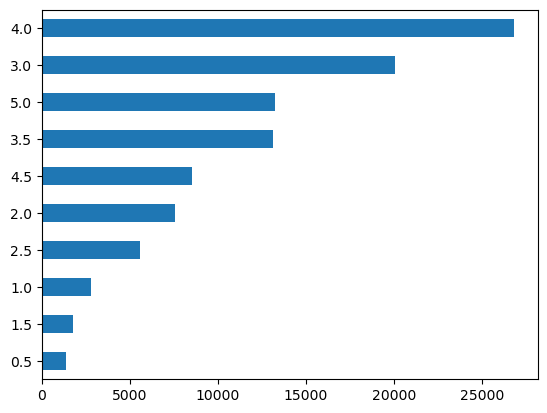

In [7]:
ratings.rating.value_counts().sort_values().plot(kind='barh')


In [8]:
combined_dataset = pd.merge(movies, ratings, how='left', on='movieId')
highest_rating = combined_dataset.groupby('title')[['rating']].count().nlargest(20, 'rating')
print(highest_rating)


                                                    rating
title                                                     
Forrest Gump (1994)                                    329
Shawshank Redemption, The (1994)                       317
Pulp Fiction (1994)                                    307
Silence of the Lambs, The (1991)                       279
Matrix, The (1999)                                     278
Star Wars: Episode IV - A New Hope (1977)              251
Jurassic Park (1993)                                   238
Braveheart (1995)                                      237
Terminator 2: Judgment Day (1991)                      224
Schindler's List (1993)                                220
Fight Club (1999)                                      218
Toy Story (1995)                                       215
Star Wars: Episode V - The Empire Strikes Back ...     211
American Beauty (1999)                                 204
Usual Suspects, The (1995)                             2

In [9]:
movies_and_users = ratings.pivot(index='movieId', columns='userId', values='rating').fillna(0)
movies_and_users


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
matrix_movies_users = csr_matrix(movies_and_users.values)
print(matrix_movies_users)


  (0, 0)	4.0
  (0, 4)	4.0
  (0, 6)	4.5
  (0, 14)	2.5
  (0, 16)	4.5
  (0, 17)	3.5
  (0, 18)	4.0
  (0, 20)	3.5
  (0, 26)	3.0
  (0, 30)	5.0
  (0, 31)	3.0
  (0, 32)	3.0
  (0, 39)	5.0
  (0, 42)	5.0
  (0, 43)	3.0
  (0, 44)	4.0
  (0, 45)	5.0
  (0, 49)	3.0
  (0, 53)	3.0
  (0, 56)	5.0
  (0, 62)	5.0
  (0, 63)	4.0
  (0, 65)	4.0
  (0, 67)	2.5
  (0, 70)	5.0
  :	:
  (9700, 337)	2.5
  (9701, 337)	3.0
  (9702, 183)	4.0
  (9702, 247)	3.5
  (9703, 317)	2.5
  (9704, 209)	1.0
  (9705, 461)	2.5
  (9706, 49)	3.5
  (9707, 337)	1.5
  (9708, 337)	4.0
  (9709, 337)	1.0
  (9710, 337)	1.5
  (9711, 337)	1.0
  (9712, 337)	1.0
  (9713, 183)	4.5
  (9714, 183)	3.5
  (9715, 183)	3.0
  (9716, 183)	4.0
  (9717, 183)	4.0
  (9718, 183)	3.5
  (9719, 183)	4.0
  (9720, 183)	3.5
  (9721, 183)	3.5
  (9722, 183)	3.5
  (9723, 330)	4.0


In [11]:

# Combine movies and ratings data into a single dataset
combined_dataset = pd.merge(movies, ratings, how='left', on='movieId')

# Create a pivot table of movies and users with ratings
movies_and_users = ratings.pivot(index='movieId', columns='userId', values='rating').fillna(0)

# Create a sparse matrix representation of the movies and users data
matrix_movies_users = csr_matrix(movies_and_users.values)


In [12]:

# Train Nearest Neighbors model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
model_knn.fit(matrix_movies_users)


NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [13]:

# Train Factorization Machines model using Surprise library
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
train_fm, test_fm = surprise_train_test_split(data)
model_fm = NMF()
model_fm.fit(train_fm)

In [14]:

# Train Neural Collaborative Filtering model using Surprise library
model_ncf = KNNBasic(sim_options={'user_based': False})
model_ncf.fit(train_fm)


Computing the msd similarity matrix...
Done computing similarity matrix.


In [15]:

# Save trained models as inference models
joblib.dump(model_knn, 'knn_model.pkl')
joblib.dump(model_fm, 'fm_model.pkl')
joblib.dump(model_ncf, 'ncf_model.pkl')

['ncf_model.pkl']

In [16]:

def recommender_knn(movie_name, data, model):
    idx = process.extractOne(movie_name, movies['title'])[2]
    print('Movie Selected: ', movies['title'][idx], 'Index: ', idx)
    print('Searching.....')
    distances, indices = model.kneighbors(data[idx], n_neighbors=10)
    for i in indices:
        print(movies['title'][i])

def recommender_fm(user_id, model, dataset, num_items=10):
    user_index = dataset.to_inner_uid(user_id)
    scores = []
    for item_index in range(dataset.n_items):
        score = model.predict(user_index, item_index).est
        scores.append(score)
    scores = np.array(scores)
    top_items = np.argsort(-scores)[:num_items]
    for item in top_items:
        print(movies['title'][movies['movieId'] == dataset.to_raw_iid(item)].iloc[0])


def recommender_ncf(user_id, model, dataset, num_items=10):
    user_index = dataset.to_inner_uid(user_id)
    scores = []
    for item_index in range(dataset.n_items):
        score = model.predict(user_index, item_index).est
        scores.append(score)
    scores = np.array(scores)
    top_items = np.argsort(-scores)[:num_items]
    for item in top_items:
        item_id = dataset.to_raw_iid(item)
        print(movies['title'][movies['movieId'] == item_id].iloc[0])



In [18]:

# Example usage
recommender_knn('matrix', matrix_movies_users, model_knn)
print("===================================================================")
recommender_fm(1, model_fm, train_fm)
print("===================================================================")
recommender_ncf(1, model_ncf, train_fm)


Movie Selected:  Matrix, The (1999) Index:  1939
Searching.....
1939                                   Matrix, The (1999)
2895                         Suddenly, Last Summer (1959)
1869    Day of the Beast, The (Día de la Bestia, El) (...
1318                           Blues Brothers 2000 (1998)
1946                                            Go (1999)
7399    Extraordinary Adventures of Adèle Blanc-Sec, T...
4935                             Kill Bill: Vol. 2 (2004)
1062                                 Young Guns II (1990)
1177                                      Hercules (1997)
3152                                          Blow (2001)
Name: title, dtype: object
How to Kill Your Neighbor's Dog (2000)
Dark Water (2005)
Sphere (1998)
Breathless (1983)
Funny Farm (1988)
Buffalo Soldiers (2001)
Bollywood/Hollywood (2002)
Oklahoma! (1955)
Miss Congeniality (2000)
Mystery of the Third Planet, The (Tayna tretey planety) (1981)
Zero Theorem, The (2013)
Pillow Book, The (1996)
Chaser, The (Chug